#  各种包

In [1]:
import pandas as pd 
import numpy as np
#from numpy.core.umath_tests import inner1d
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from collections import Counter

# modelos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import  ExtraTreesClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,confusion_matrix,precision_recall_curve,auc,roc_curve,recall_score, classification_report
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


import sys

# 数据导入

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 预处理 

In [4]:
# data1 : without id
data = data.drop(['id'], axis=1)


In [5]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
data.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [7]:
label = [1,2,3,4,5]
data["age_mean"] = pd.cut(data["age"], 5, labels = label)
data["age_mean"].value_counts()
bmi_group = data.groupby("age_mean")["bmi"].mean() #将年龄阶段分为五组，分别计算平均的bmi
bmi_group

age_mean
1    20.787661
2    28.601332
3    31.425088
4    31.580618
5    29.415118
Name: bmi, dtype: float64

In [8]:
def bmi_val(cols): #给 bmi 按年龄分配平均值
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi

In [9]:
data["bmi"] = data[["bmi","age_mean"]].apply(bmi_val, axis=1)

In [10]:
data.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_mean             0
dtype: int64

In [11]:
data.gender = data.gender.apply(
    lambda x: 0 
    if ((x == 'Female') or (x == 'Other')) 
    else 1)

#将other 改成 Female

In [12]:
data.gender.value_counts()

0    2995
1    2115
Name: gender, dtype: int64

In [13]:
data['age'] = data['age'].apply(lambda x: round(x))
data['age']

0       67
1       61
2       80
3       49
4       79
        ..
5105    80
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 5110, dtype: int64

# 数据类型转换

In [14]:
ohe = OneHotEncoder(drop = 'first', sparse=False, handle_unknown = 'error')
data_t = pd.DataFrame(ohe.fit_transform(data.select_dtypes('object')))

data_t.columns = ohe.get_feature_names()
data_t.head(2)
data_t.shape

(5110, 9)

In [15]:
data_n = data.drop(data.select_dtypes('object'), axis=1)

data = pd.concat([data_t, data_n], axis=1)
data.head(5)

,x0_Yes,x1_Never_worked,x1_Private,x1_Self-employed,x1_children,x2_Urban,x3_formerly smoked,x3_never smoked,x3_smokes,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_mean
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,67,0,1,228.69,36.6,1,5
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,61,0,0,202.21,31.6,1,4
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,80,0,1,105.92,32.5,1,5
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,49,0,0,171.23,34.4,1,3
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,79,1,0,174.12,24.0,1,5


In [16]:
X = data.drop(columns=['stroke'])
y = data['stroke']

In [17]:
X.isnull().sum()

x0_Yes                0
x1_Never_worked       0
x1_Private            0
x1_Self-employed      0
x1_children           0
x2_Urban              0
x3_formerly smoked    0
x3_never smoked       0
x3_smokes             0
gender                0
age                   0
hypertension          0
heart_disease         0
avg_glucose_level     0
bmi                   0
age_mean              0
dtype: int64

In [18]:
smote=SMOTE(random_state=42)
x_smote,y_smote=smote.fit_resample(X,y)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.33,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# 调整和补充数据

In [20]:
# Rescaling Data
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
for i in range(len(X_train)):
    sample= X_train[i]
    for j in range(len(sample)):
        if np.isnan(sample[j]):
            sample[j]=0 

print(np.isnan(X_train).any())
            
for i in range(len(X_test)):
    sample= X_test[i]
    for j in range(len(sample)):
        if np.isnan(sample[j]):
            sample[j]=0 
print(np.isnan(X_test).any())

False
False


# 输出

In [22]:
LR=LogisticRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [23]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       803
           1       0.77      0.83      0.80       802

    accuracy                           0.79      1605
   macro avg       0.79      0.79      0.79      1605
weighted avg       0.79      0.79      0.79      1605



In [24]:
auc = roc_auc_score(y_test, y_pred)
auc

0.7900570802135384

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[601, 202],
       [135, 667]])

In [26]:
predicted_probab_log = LR.predict_proba(X_test)
predicted_probab_log = predicted_probab_log[:, 1]
fpr, tpr, _ = roc_curve(y_test, predicted_probab_log)

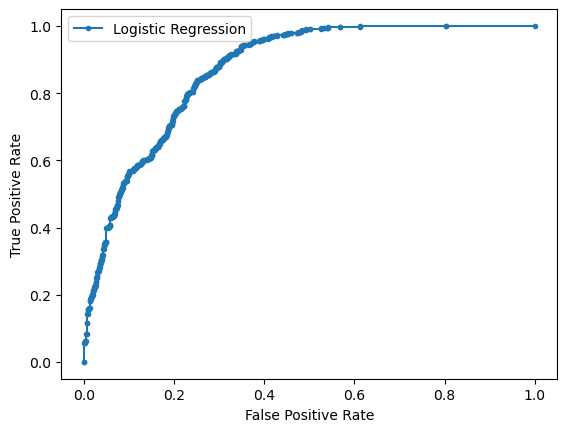

In [27]:
pyplot.plot(fpr, tpr, marker='.', label='Logistic Regression')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()